In [80]:
import pickle
import pandas as pd
import matplotlib
import os
import re

import scipy

import collections
import datetime
import time

import geopandas as gpd

import numpy as np
 
from difflib import get_close_matches

from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from sklearn import linear_model

import statsmodels.api as sm
import statsmodels.formula.api as smf

from linearmodels import PanelOLS, FamaMacBeth
from scipy import stats

import itertools

import matplotlib.pyplot as plt

from numpy.linalg import matrix_rank

import seaborn as sns

import string

from matplotlib.transforms import Affine2D


In [5]:
os.getcwd()

'/Users/brianreed/Documents/supplyChain/extremes/extremesAnalysisCode'

In [67]:
tableData = pd.read_table("../../data/companyData/all_byPrecipTercile.txt",
                         header = 1, dtype = 'str').dropna(axis = 0, how = 'all')
cols = ['VARIABLES']
tableData.loc[:,cols] = tableData.loc[:,cols].ffill()
tableData['LABELS']   = tableData['LABELS'].fillna('stdErrors')

lastRow = list(tableData.VARIABLES).index('Observations')

tableData = tableData.iloc[0:lastRow,:]
for col in tableData.columns[2:]:
    tableData[col] = tableData[col].astype('str').str.replace('*', '').str.replace('(', '').str.replace(')', '').astype('float64')

tableData.head()


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()


,VARIABLES,LABELS,excessrain,excessrainemp,excessrainnational,extremeprecipquarterly
1,1bn.preciptercile,"precipTercile = 1b,",-0.001300,-0.000656,-0.001130,-0.01130
2,1bn.preciptercile,stdErrors,0.000678,0.000695,0.000951,0.00617
3,2.preciptercile,precipTercile = 2,-0.000293,-0.000786,-0.000062,-0.00501
4,2.preciptercile,stdErrors,0.000504,0.000550,0.000678,0.00424
5,3.preciptercile,precipTercile = 3,-0.001700,-0.002060,-0.001920,-0.01930


In [77]:
tableData.head()

,VARIABLES,LABELS,excessrain,excessrainemp,excessrainnational,extremeprecipquarterly
1,1bn.preciptercile,"precipTercile = 1b,",-0.001300,-0.000656,-0.001130,-0.01130
2,1bn.preciptercile,stdErrors,0.000678,0.000695,0.000951,0.00617
3,2.preciptercile,precipTercile = 2,-0.000293,-0.000786,-0.000062,-0.00501
4,2.preciptercile,stdErrors,0.000504,0.000550,0.000678,0.00424
5,3.preciptercile,precipTercile = 3,-0.001700,-0.002060,-0.001920,-0.01930


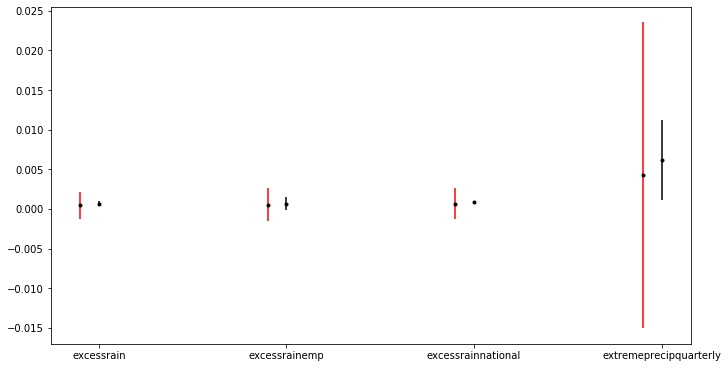

In [86]:
x   = tableData.columns[2:]

y1      = tableData.iloc[1,2:]
errors1 = tableData.iloc[2,2:]

y2      = tableData.iloc[3,2:]
errors2 = tableData.iloc[4,2:]



xdim = 10
ydim = 5
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all',
                                  figsize=(xdim,ydim),
                                  constrained_layout=True)

plt.errorbar(x,y1,yerr = errors1, fmt = '.k')

trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
plt.errorbar(x,y2,yerr = errors2, fmt = '.k', transform = trans1, ecolor = 'red')

'''ax[rowIndex, colIndex].xaxis.grid(False)
ax[rowIndex, colIndex].yaxis.grid(False)
ax[rowIndex, colIndex].axhline(y=0)
ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + yLims, yLims/2))
ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
ax[rowIndex, colIndex].set_title(ind, fontsize = 24)'''
plt.show()

In [ ]:
def makePlots(results, industries, filePrefix, yLim, numCol = 2, padding = 1, xdim = 20, ydim = 40):
    
    # loop over outcome variables and weather definitions
    weatherVars = results.weatherVar.unique()
    outcomeVars = results.outcomeVar.unique()


    for outcome in outcomeVars:
        for weather in weatherVars:
            # choose the elective parts of this - number of columns and the range of the axes
            numCols = numCol
            yLims   = yLim

            rowNum = len(industries) // numCols + padding
            colNum = numCols

            fig, ax = plt.subplots(rowNum, colNum, sharex='all', sharey='all',
                                  figsize=(xdim,ydim),
                                  constrained_layout=True)

            fig.suptitle('Direct Effects: ' + outcome + ' ~ ' + weather, fontsize=36)



            i = 0
            for ind in industries:
                rowIndex = i // numCols 
                colIndex = i % numCols


                i   = i + 1


                rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                             (results.industry == ind)].reset_index()
                # indName = rev.industryName.unique()[0]
                x   = [0,1,2,3,4]
                y   = [rev.lag0,rev.lag1,rev.lag2,rev.lag3,rev.lag4]


                errors = [rev.bse0,rev.bse1,rev.bse2,rev.bse3,rev.bse4]


                ax[rowIndex, colIndex].errorbar(x,y,yerr = errors, fmt = '.k')
                ax[rowIndex, colIndex].xaxis.grid(False)
                ax[rowIndex, colIndex].yaxis.grid(False)
                ax[rowIndex, colIndex].axhline(y=0)
                ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

                ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + yLims, yLims/2))
                ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

                ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
                ax[rowIndex, colIndex].set_title(ind, fontsize = 24)

            fig.savefig(filePrefix + outcome + weather + '.png')
            fig.show()


                # ax[rowIndex, colIndex].



